In [1]:
from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential

import numpy as np

from sklearn.calibration import calibration_curve
from sklearn import metrics

/home/andrew/Envs/calibration/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def ece(predictions, confidences, labels, n_bins=10, max_ece=False):
    # Get the different bins
    bins = np.linspace(0, 1, n_bins + 1)
    low_bins = bins[:-1]
    up_bins = bins[1:]
    all_bins = zip(low_bins, up_bins)
    
    num_samples = predictions.shape[0]
    ece_bin_values = []
    # For each bin work out the weighted difference between  
    # confidence and accuracy
    for low_bin, up_bin in all_bins:
        bin_conf_indcies = np.nonzero((confidences > low_bin) &
                                      (confidences <= up_bin))
        bin_confs = confidences[bin_conf_indcies]
        bin_preds = predictions[bin_conf_indcies]
        bin_labels = labels[bin_conf_indcies]
        
        num_samples_in_bin = bin_confs.shape[0]
        if num_samples_in_bin == 0:
            ece_bin_values.append(0)
            continue
        bin_weight = num_samples_in_bin / num_samples
        
        bin_acc = (bin_labels == bin_preds).mean()
        bin_mean_conf = bin_confs.mean()
        
        bin_acc_conf_diff = abs(bin_acc - bin_mean_conf)
        weighted_diff = bin_weight * bin_acc_conf_diff
        ece_bin_values.append(weighted_diff)
    # Return the max ece or the weighted average
    print(' '.join([f'{ece_value:.2f}'for ece_value in ece_bin_values]))
    if max_ece:
        return max(ece_bin_values)
    else:
        total_weighted_ece = sum(ece_bin_values)
        return total_weighted_ece

In [3]:
ngram_range = 1
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features,
                                                      seed=113)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print(f'Average train sequence length: {np.mean(list(map(len, x_train)))}')
print(f'Average test sequence length: {np.mean(list(map(len, x_test)))}')

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238.71364
Average test sequence length: 230.8042


In [4]:
# This makes all of the sequences the same size
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


In [5]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(layers.Embedding(max_features,
                           embedding_dims,
                           input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(layers.GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
train_eces = []
train_max_eces = []
train_accs = []
train_cross_entropys = []
train_abs_calibration = []
train_mse_calibration = []

val_eces = []
val_max_eces = []
val_accs = []
val_cross_entropys = []
valid_abs_calibration = []
valid_mse_calibration = []

for j in range(1, 50):
    print(f'epoch {j}')
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=1,
          validation_data=(x_test, y_test))
    
    preds_train = model.predict(x_train)
    preds_val = model.predict(x_test)
    
    conf_train = preds_train.max(axis=1)
    conf_val = preds_val.max(axis=1)
    
    preds_train_labels = np.round(preds_train).reshape(preds_train.shape[0],)
    preds_val_labels = np.round(preds_val).reshape(preds_val.shape[0],)

    
    train_ece = ece(preds_train_labels, conf_train, y_train, n_bins=15)
    train_eces.append(train_ece)
    train_max_ece = ece(preds_train_labels, conf_train, y_train, max_ece=True, n_bins=15)
    train_max_eces.append(train_max_ece)
    train_cat_acc = metrics.accuracy_score(y_train, preds_train_labels)
    train_accs.append(train_cat_acc)
    train_cross_entropy = metrics.log_loss(y_train, preds_train)
    train_cross_entropys.append(train_cross_entropy)
    
    train_empirical_probs, train_predicted_probs= calibration_curve(y_train , conf_train,n_bins=15)
    train_abs_cal = abs(train_empirical_probs - train_predicted_probs).mean()
    train_mse_cal = ((train_empirical_probs - train_predicted_probs)**2).mean()
    train_abs_calibration.append(train_abs_cal)
    train_mse_calibration.append(train_mse_cal)
    print(f'Train: ece {train_ece:.2f} max ece {train_max_ece:.2f} acc '
          f'{train_cat_acc:.2f} entropy {train_cross_entropy:.2f}'
          f'cal abs {train_abs_cal:.2f} cal mse {train_mse_cal:.2f}')
    
    val_ece = ece(preds_val_labels, conf_val, y_test, n_bins=15)
    val_eces.append(val_ece)
    val_max_ece = ece(preds_val_labels, conf_val, y_test, max_ece=True, n_bins=15)
    val_max_eces.append(val_max_ece)
    val_cat_acc = metrics.accuracy_score(y_test, preds_val_labels)
    val_accs.append(val_cat_acc)
    val_cross_entropy = metrics.log_loss(y_test, preds_val)
    val_cross_entropys.append(val_cross_entropy)
    
    valid_empirical_probs, valid_predicted_probs= calibration_curve(y_test , conf_val,n_bins=15)
    val_abs_cal = abs(valid_empirical_probs - valid_predicted_probs).mean()
    val_mse_cal = ((valid_empirical_probs-valid_predicted_probs)**2).mean()
    valid_abs_calibration.append(val_abs_cal)
    valid_mse_calibration.append(val_mse_cal)
    print(f'Val: ece {val_ece:.2f} max ece {val_max_ece:.2f} '
          f'acc {val_cat_acc:.2f} entropy {val_cross_entropy:.2f}'
          f'cal abs {val_abs_cal:.2f} cal mse {val_mse_cal:.2f}')

epoch 1
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 39s 2ms/step - loss: 0.6746 - acc: 0.6548 - val_loss: 0.6471 - val_acc: 0.7736
0.00 0.00 0.00 0.00 0.00 0.01 0.11 0.12 0.06 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.01 0.11 0.12 0.06 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.30 max ece 0.12 acc 0.79 entropy 0.64cal abs 0.31 cal mse 0.11
0.00 0.00 0.00 0.00 0.00 0.01 0.10 0.11 0.05 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.01 0.10 0.11 0.05 0.00 0.00 0.00 0.00 0.00 0.00
Val: ece 0.28 max ece 0.11 acc 0.77 entropy 0.65cal abs 0.30 cal mse 0.10
epoch 2
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 38s 2ms/step - loss: 0.6044 - acc: 0.7822 - val_loss: 0.5707 - val_acc: 0.7870
0.00 0.00 0.01 0.02 0.05 0.08 0.06 0.02 0.05 0.03 0.01 0.01 0.00 0.00 0.00
0.00 0.00 0.01 0.02 0.05 0.08 0.06 0.02 0.05 0.03 0.01 0.01 0.00 0.00 0.00
Train: ece 0

/home/andrew/Envs/calibration/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/home/andrew/Envs/calibration/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


25000/25000 [==============================] - 38s 2ms/step - loss: 0.2116 - acc: 0.9280 - val_loss: 0.2874 - val_acc: 0.8876
0.26 0.07 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00
0.26 0.07 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00
Train: ece 0.44 max ece 0.26 acc 0.93 entropy nancal abs 0.09 cal mse 0.01
0.23 0.06 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.23 0.06 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Val: ece 0.40 max ece 0.23 acc 0.89 entropy nancal abs 0.05 cal mse 0.00
epoch 13
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 38s 2ms/step - loss: 0.2010 - acc: 0.9329 - val_loss: 0.2857 - val_acc: 0.8874
0.28 0.07 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00
0.28 0.07 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00
Train: ece 0.45 max ece 0.28 acc 0.94 entropy nancal abs 0.09 cal mse 0.01
0.25 0

25000/25000 [==============================] - 38s 2ms/step - loss: 0.1181 - acc: 0.9650 - val_loss: 0.2862 - val_acc: 0.8882
0.35 0.05 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.35 0.05 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.47 max ece 0.35 acc 0.97 entropy nancal abs 0.10 cal mse 0.01
0.30 0.04 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.30 0.04 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Val: ece 0.40 max ece 0.30 acc 0.89 entropy nancal abs 0.02 cal mse 0.00
epoch 26
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 38s 2ms/step - loss: 0.1132 - acc: 0.9669 - val_loss: 0.2889 - val_acc: 0.8871
0.35 0.05 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.35 0.05 0.02 0.01 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.47 max ece 0.35 acc 0.97 entropy nancal abs 0.10 cal mse 0.01
0.30 0

25000/25000 [==============================] - 38s 2ms/step - loss: 0.0695 - acc: 0.9828 - val_loss: 0.3340 - val_acc: 0.8784
0.40 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.40 0.04 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.48 max ece 0.40 acc 0.98 entropy nancal abs 0.10 cal mse 0.01
0.34 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
0.34 0.03 0.02 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01
Val: ece 0.42 max ece 0.34 acc 0.88 entropy nancal abs 0.05 cal mse 0.00
epoch 39
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 38s 2ms/step - loss: 0.0666 - acc: 0.9835 - val_loss: 0.3410 - val_acc: 0.8770
0.41 0.03 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.41 0.03 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
Train: ece 0.49 max ece 0.41 acc 0.99 entropy nancal abs 0.11 cal mse 0.02
0.35 0

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Accuracy

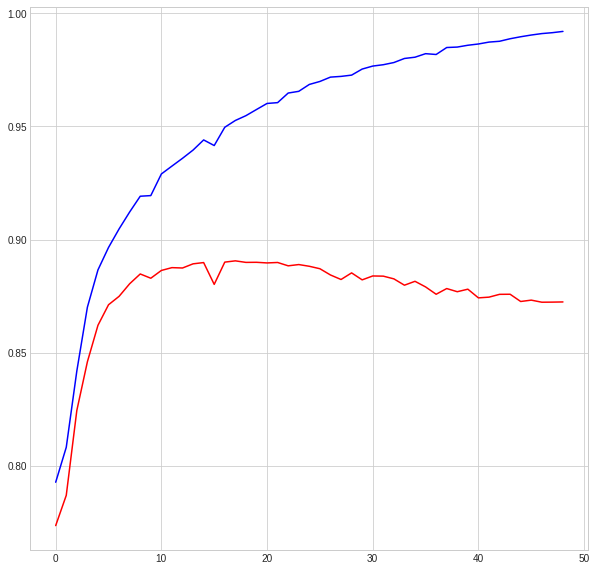

In [8]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_accs, 'b')
plt.plot(val_accs, 'r')
plt.savefig('accuracy.png', dpi = 300)

In [18]:
np.array(val_accs).argmax()

17

In [26]:
val_accs[10]

0.88636

In [23]:
val_accs[17]

0.8906

In [22]:
val_accs[23]

0.88896

# Cross Entropy

Got NAN values after 10 epochs

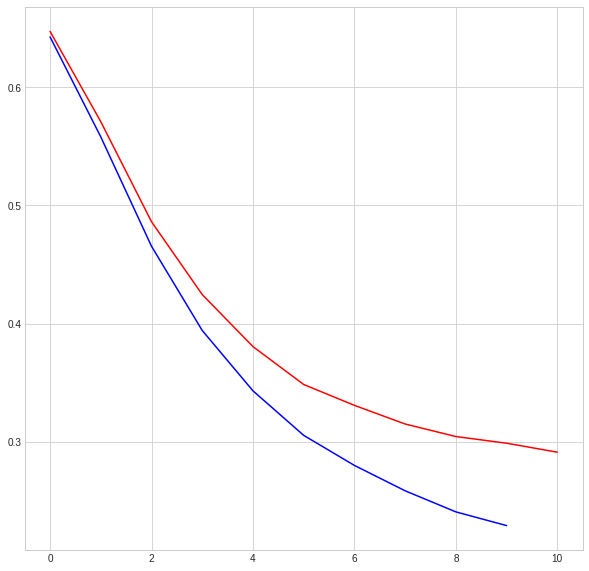

In [14]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_cross_entropys, 'b')
plt.plot(val_cross_entropys, 'r')
plt.savefig('cross entropy.png', dpi = 300)

# ECE

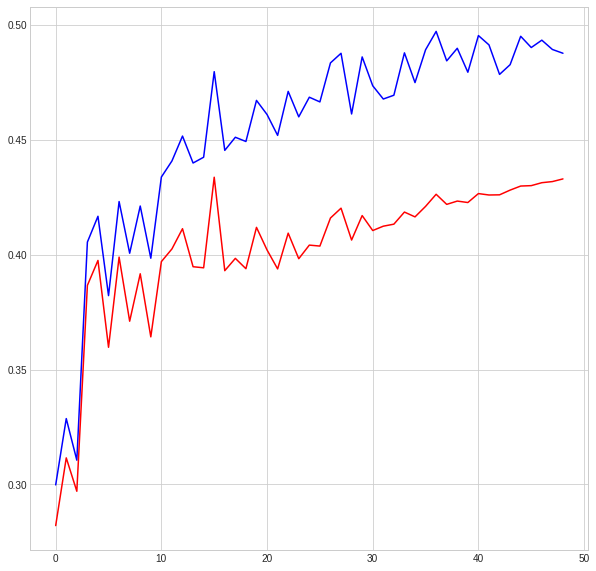

In [10]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_eces, 'b')
plt.plot(val_eces, 'r')
plt.savefig('ece.png', dpi = 300)

# Absolute Calibration

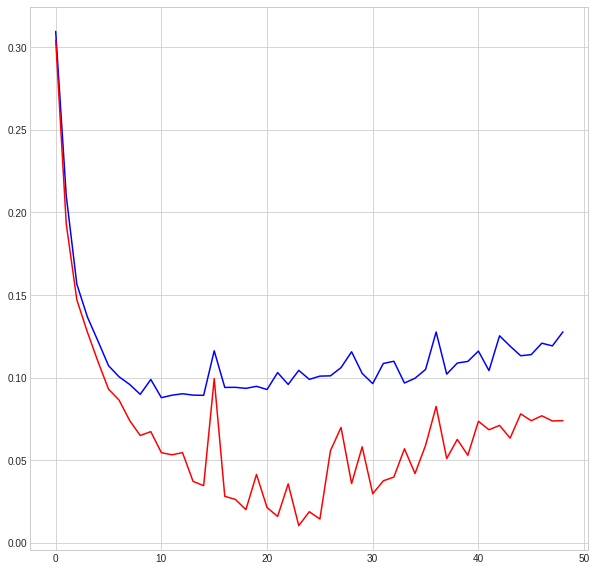

In [11]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_abs_calibration, 'b')
plt.plot(valid_abs_calibration, 'r')
plt.savefig('Absolute Calibration.png', dpi = 300)

In [19]:
np.array(valid_abs_calibration).argmin()

23

In [24]:
np.array(train_abs_calibration).argmin()

10

# MCE

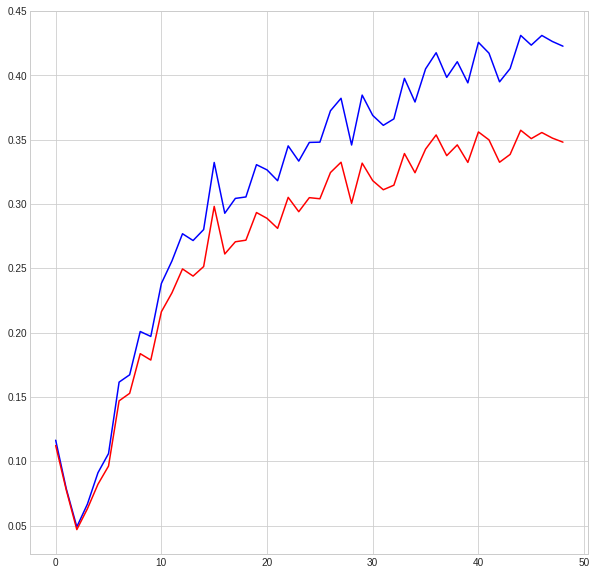

In [12]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_max_eces, 'b')
plt.plot(val_max_eces, 'r')
plt.savefig('mce.png', dpi = 300)

# MSE Calibration

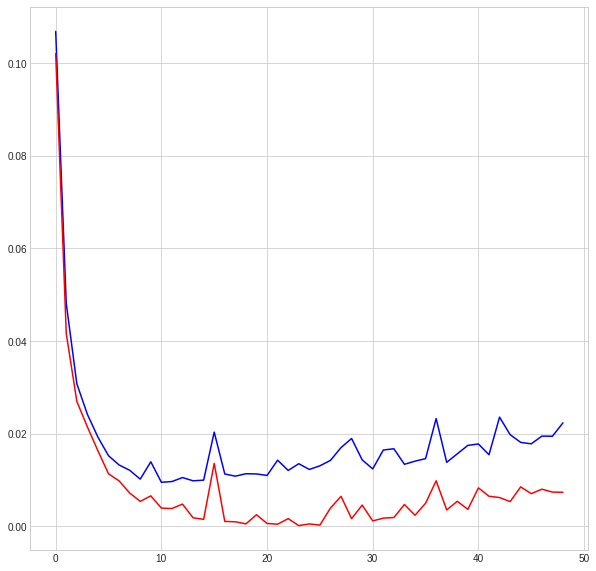

In [13]:
fig=plt.figure(figsize=(10,10))
plt.plot(train_mse_calibration, 'b')
plt.plot(valid_mse_calibration, 'r')
plt.savefig('MSE Calibration.png', dpi = 300)

In [20]:
np.array(valid_abs_calibration).argmin()

23

In [25]:
np.array(train_abs_calibration).argmin()

10